# CS 449 Final Project Proposal

Due: April 21, 2023 at 11:59pm

## 1. Names and Net IDs

Adam Holeman - agh4973

Jason Huang - jjh9397

Divy Kumar - dko6133

## 2. Abstract

Our final project aims to generate images from a user-specified class in the CIFAR-10 dataset. We will compare a diffusion model with a GAN model using the FID metric for image quality. Time permitting, we will also train these models on different datasets with slightly larger resolution images.

## 3. Introduction

Generative models have recently attracted much attention and have wide ranging applications. Both GAN's and diffusion models are able to generate perceptually detailed images, and have played a big role in recent developments in image generation. We want to create and compare these models to better understand how they work. The CIFAR-10 dataset consists of 60,000 images each of which is 32x32 pixels and is separated in to 10 classes. We will train a model to generate images in each of these classes.

## 4a. Describe your dataset(s)

The CIFAR-10 (Canadian Institute for Advanced Research) dataset consists of 60,000 images each of which is 32x32 pixels and is separated in to 10 classes. The data can be found at the following link: https://paperswithcode.com/dataset/cifar-10. The 10 labels are airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck. This dataset has been used as a benchmark in various imaging tasks, and in particular as an image generation benchmark. The following two papers use the CIFAR-10 dataset to train models related to the goals of our project:

Wang, Zhendong, et al. ‘Diffusion-GAN: Training GANs with Diffusion’. ArXiv [Cs.LG], 2022, http://arxiv.org/abs/2206.02262. arXiv.

Ho, Jonathan, et al. ‘Denoising Diffusion Probabilistic Models’. ArXiv [Cs.LG], 2020, http://arxiv.org/abs/2006.11239. arXiv.

The citation for the dataset itself is included below.

Krizhevsky, Alex. "Learning Multiple Layers of Features from Tiny Images." (2009)

## 4b. Load your dataset(s)

100%|██████████| 170498071/170498071 [00:14<00:00, 11649988.16it/s]


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


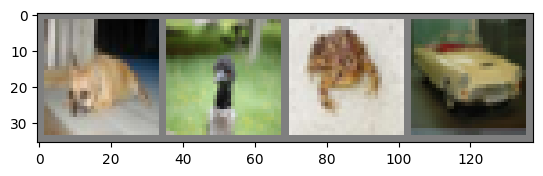

dog   bird  frog  car  


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
batch_size = 4
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## 4c. Small dataset

Since our images are already relatively small (32x32) for our purpose of generating images, we will limit the dataset to specific classes to create a small dataset and possibly the first 3000 examples if necessary to reduce size further. This makes sense for our purpose because generating images from a single class is still meaningful for our goals.

Our current dataset has 10 classes and 6000 examples per class for a total of approximately 160MB. Therefore, taking just a single class will approximately divide the size by 10, and taking the first 3000 examples of that class will approximately halve the size further to give a dataset that is less than 10MB in size.

## 5. Methods

Our primary goal is to implement a diffusion model and train it on the CIFAR-10 dataset. Here's a super brief summary of where these models come from.

<h1> <center> Basic Model Setup </center> </h1>
Diffusion models aim to approximate a probability distribution $p_{\theta}(x)$ over the input data $x$ by incorporating a set of latent variables (i.e. variable which are not observed in the data - meant to represent some 'features' of the data which the algorithm might observe), $z_{1},..., z_{t}$. By modeling a joint distribution $p_{\theta}(x, z_{1},..., z_{t})$, one reconstructs the distribution $p_{\theta}(x)$ by marginalizing with respect to the latent variables $z_{i}$. The joint distribution decomposes as a product of conditional distributions
\begin{align}
p_{\theta}(x, z_{i}) = p_{\theta}(x|z_{1}) \left(\prod_{i=1}^{t-1} p_{\theta}(z_{i} | z_{i+1}) \right) p_{\theta}(z_{t})
\end{align}
and each of these distributions is parameterized by a deep neural network. The posterior distribution $p_{\theta}(z_{1} | x)$ is typically intractable, so we introduce an auxiliary distribution $q_{\phi}(z_{1}|x)$ (as well as distributions $q_{\phi}(z_{i+1}| z_{i})$) which aims to approximate the posterior distribution, which we also parameterize by neural networks.



For more specific architectural details in the models (structure of the parameterizing neural networks, values of the many hyperparameters, etc...) we will likely adopt conventions from the literature. See Citations 2 and 3 below.

<h1> <center> Training Method </center> </h1>

In the above context, there are two related objectives to optimize:
- Given some data $x$, we would like maximize the log-likelihood of the marginal distribution: $log(p_{\theta}(x))$. This improves the generative model.

- We would also like to ensure that our model $q_{\phi}(z_{1}|x)$ is a good approximation of the intractable posterior distribution $p_{\theta}(z_{1}|x)$, as for example measured by the Kullback-Leibler divergence: $D_{KL}(q_{\phi}(z_{1}|x)| p_{\theta}(z_{1}|x)$.

These two goals can be accomplished simultaneously by maximizing the 'evidence lower bound', abbreviated by ELBO. See citation 1 below.

In order to make optimization tractable, we will impose some hypotheses on these distributions - e.g. we'll start by taking the $q_{\phi}$ to be Gaussians
\begin{align}
q_{\phi}(z_{i}| z_{i-1}) = \mathcal{N}(z_{i} | \alpha_{t} z_{i-1}, \beta_{i} I)
\end{align}
for some hyperparameters $\alpha_{i}$ and $\beta_{i}$. Imposing a similar hypothesis on the prior distribution $p_{\theta}(z_{t})$ places us in a context where we can apply gradient based methods to optimize the ELBO using the reparameterization trick of Kingma and Welling (see Citation 1 below).


**Citations**

1 - Kingma, Diederik P., and Max Welling. ‘Auto-Encoding Variational Bayes’. ArXiv [Stat.ML], 2022, http://arxiv.org/abs/1312.6114. arXiv.

2 - Ho, Jonathan, et al. ‘Denoising Diffusion Probabilistic Models’. ArXiv [Cs.LG], 2020, http://arxiv.org/abs/2006.11239. arXiv.

3 - Kingma, Diederik P., et al. ‘Variational Diffusion Models’. ArXiv [Cs.LG], 2023, http://arxiv.org/abs/2107.00630. arXiv.

## 6. Deliverables

### 6.1 Essential Goals
- We will train a diffusion model on a single class of our CIFAR-10 data to be able to generate images from an image input
- We will evaluate the performance of the model using a metric such as FID
- We will compare the generated images against a pretrained GAN model

### 6.2 Desired Goals
- We will train the diffusion model on the entire CIFAR-10 dataset and generate images of good quality i.e. an image classifier can detect the right class from the generated image; FID score < ~100?
- We will train a GAN on the CIFAR-10 dataset and compare the results with our diffusion model

### 6.3 Stretch Goals
- We will use a dataset with larger images and generates images of higher resolution with the diffusion model
- We will compare the results from above goal with a pretrained GAN and/or a GAN we train on the same dataset


## 7. Hopes and Concerns

We're excited about seeing the output images we can generate and how they can change as we tune the model.

## 8. References

 

 Kingma, Diederik P., and Max Welling. ‘Auto-Encoding Variational Bayes’. ArXiv [Stat.ML], 2022, http://arxiv.org/abs/1312.6114. arXiv.

 Ho, Jonathan, et al. ‘Denoising Diffusion Probabilistic Models’. ArXiv [Cs.LG], 2020, http://arxiv.org/abs/2006.11239. arXiv.

 Kingma, Diederik P., et al. ‘Variational Diffusion Models’. ArXiv [Cs.LG], 2023, http://arxiv.org/abs/2107.00630. arXiv.
 
 Wang, Zhendong, et al. ‘Diffusion-GAN: Training GANs with Diffusion’. ArXiv [Cs.LG], 2022, http://arxiv.org/abs/2206.02262. arXiv.
 
 Krizhevsky, Alex. "Learning Multiple Layers of Features from Tiny Images." (2009)


https://paperswithcode.com/sota/image-generation-on-cifar-10